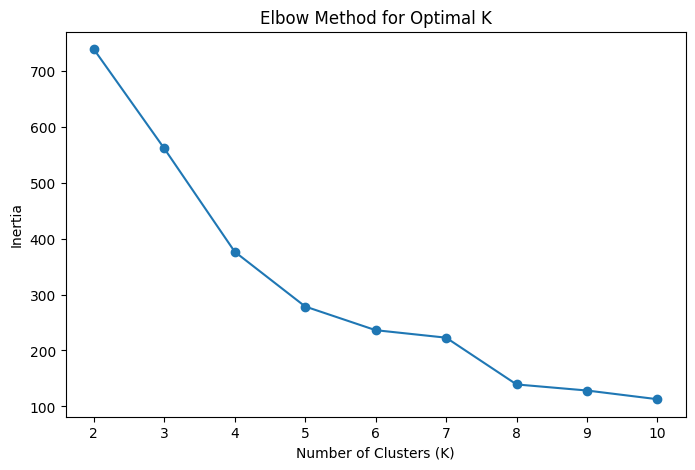

Davies-Bouldin Index: 0.9757


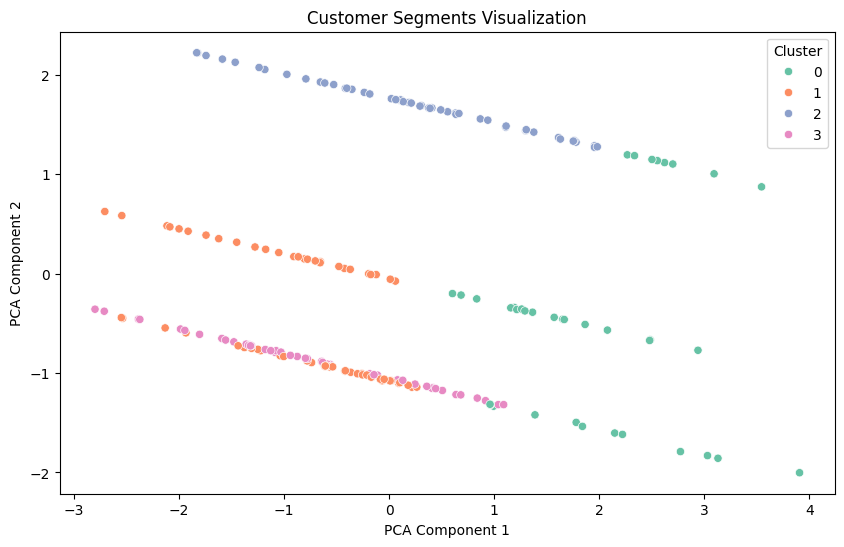

Customer segmentation complete. Results saved to Customer_Segments.csv.


In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
transactions_df = pd.read_csv('Transactions.csv')
customers_df = pd.read_csv('Customers.csv')

# Merge data for customer transaction aggregation
customer_transactions = transactions_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum'  # Total quantity purchased
}).reset_index()

# Merge with customer profiles
customer_data = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)  # Fill missing transaction data with 0

# Encode categorical features
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1))

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Choose an optimal K and fit the K-Means model
optimal_k = 4  # Based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)

# Add cluster labels to the customer data
customer_data['Cluster'] = kmeans.labels_

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Visualize the clusters (using the first two principal components for simplicity)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
customer_data['PCA1'] = pca_components[:, 0]
customer_data['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segments Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Save clustering results
customer_data[['CustomerID', 'Cluster']].to_csv('Customer_Segments.csv', index=False)

print("Customer segmentation complete. Results saved to Customer_Segments.csv.")
